In [9]:
import os
import pandas as pd
import numpy as np
from pymannkendall import original_test
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import matplotlib as mpl

# Set global font sizes - for manuscript
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24
mpl.rcParams['legend.fontsize'] = 18

In [14]:
# ———— USER CONFIG ————
Galeazzi_file  = r"C:\Users\Feifei\Box\BR_remote_sensing\Galeazzi_eBI.csv"
root_dir       = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_results"
discharge_dir  = r"C:\Users\Feifei\Box\BR_remote_sensing\water_discharge_data\processed"
output_csv     = r"C:\Users\Feifei\Box\BR_remote_sensing\river_mk_trends.csv"
# ————————————————————

# Load discharge IDs + lat/lon from the Galeazzi file
galeazzi_df = (
    pd.read_csv(
        Galeazzi_file,
        usecols=[
            'River_Station',
            'ID_discharge',
            'Latitude (deg)',
            'Longitude (deg)'
        ]
    )
    .set_index('River_Station')
)

results = []

for river in os.listdir(root_dir):
    rivgraph = os.path.join(root_dir, river, 'rivgraph')
    if not os.path.isdir(rivgraph):
        continue

    # —— 1) Annual eBI series ——
    ebi_csv = os.path.join(rivgraph, 'eBI_results_annual.csv')
    if not os.path.exists(ebi_csv):
        continue

    ebi_df = pd.read_csv(ebi_csv)
    if 'Year' not in ebi_df.columns or 'eBI' not in ebi_df.columns:
        continue

    annual_ebi = ebi_df.groupby('Year')['eBI'].mean()

    # Mann–Kendall on eBI with checks
    if len(annual_ebi.dropna()) >= 3 and annual_ebi.nunique() > 1:
        try:
            mk_ebi    = original_test(annual_ebi)
            ebi_trend = mk_ebi.trend
            ebi_p     = mk_ebi.p
        except ZeroDivisionError:
            ebi_trend, ebi_p = 'no trend', np.nan
    else:
        ebi_trend, ebi_p = 'no trend', np.nan

    # —— 2) Annual discharge series ——
    if river not in galeazzi_df.index:
        continue
    galeazzi_row = galeazzi_df.loc[river]
    discharge_id = galeazzi_row['ID_discharge']
    if pd.isna(discharge_id):
        continue

    discharge_file = f"{discharge_id}.csv"
    discharge_path = os.path.join(discharge_dir, discharge_file)
    if not os.path.exists(discharge_path):
        continue

    # original read logic
    discharge_df = pd.read_csv(discharge_path)
    discharge_df['date'] = pd.to_datetime(discharge_df['date'], format='%m/%d/%Y')
    discharge_df['Year'] = discharge_df['date'].dt.year

    annual_q = discharge_df.groupby('Year')['Q'].mean()

    # Mann–Kendall on discharge with checks
    if len(annual_q.dropna()) >= 3 and annual_q.nunique() > 1:
        try:
            mk_q    = original_test(annual_q)
            q_trend = mk_q.trend
            q_p     = mk_q.p
        except ZeroDivisionError:
            q_trend, q_p = 'no trend', np.nan
    else:
        q_trend, q_p = 'no trend', np.nan

    # collect lat/lon
    lat = galeazzi_row['Latitude (deg)']
    lon = galeazzi_row['Longitude (deg)']

    results.append({
        'River':               river,
        'Latitude (deg)':      lat,
        'Longitude (deg)':     lon,
        'eBI_trend':           ebi_trend,
        'eBI_p_value':         ebi_p,
        'Discharge_trend':     q_trend,
        'Discharge_p_value':   q_p
    })

# —— 3) Save summary ——
results_df = pd.DataFrame(results)
results_df.to_csv(output_csv, index=False)
print(f"Mann–Kendall trends (with lat/lon) saved to {output_csv}")
print(results_df)




Mann–Kendall trends (with lat/lon) saved to C:\Users\Feifei\Box\BR_remote_sensing\river_mk_trends.csv
                          River  Latitude (deg)  Longitude (deg)   eBI_trend  \
0   Aladan_VerkhoyanskiyPerevoz           63.32           132.02    no trend   
1            Amazonas_Jatuarana           -3.06           -59.65    no trend   
2           Amazonas_Tamshiyacu           -4.00           -73.16    no trend   
3                AmuDarya_Kerki           37.83            65.25    no trend   
4               Amur_Khabarovsk           48.43           135.05    no trend   
..                          ...             ...              ...         ...   
92                  Yukon_Eagle           64.79          -141.20    no trend   
93     Yukon_NearStevensVillage           65.88          -149.72  increasing   
94        Zambezi_LukuluMission          -14.38            23.23    no trend   
95         Zambezi_Matundo-Cais          -16.15            33.59  decreasing   
96              Za

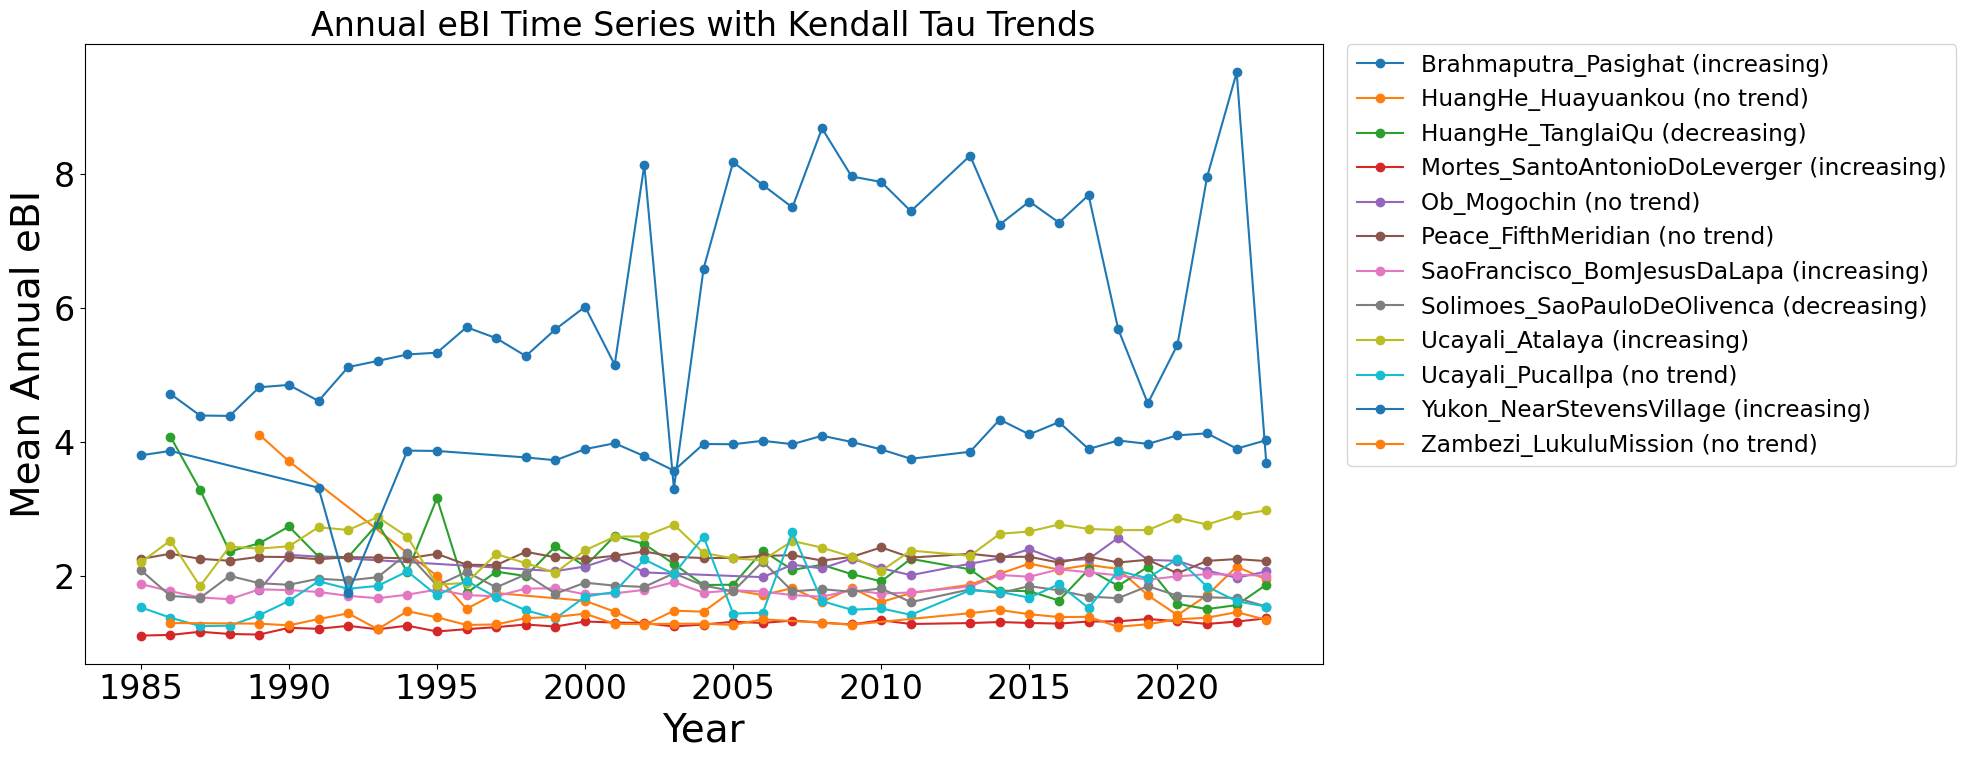

In [11]:
# List of rivers to plot
rivers = [
    "Brahmaputra_Pasighat",
    "Chulym_Baturino",
    "HuangHe_Huayuankou",
    "HuangHe_TanglaiQu",
    "Mortes_SantoAntonioDoLeverger",
    "Ob_Mogochin",
    "Peace_FifthMeridian",
    "Red_Index",
    "SaoFrancisco_BomJesusDaLapa",
    "Solimoes_SaoPauloDeOlivenca",
    "Ucayali_Atalaya",
    "Ucayali_Pucallpa",
    "Yukon_NearStevensVillage",
    "Zambezi_LukuluMission"
]

root_dir = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_results"

plt.figure(figsize=(20, 8))

for river in rivers:
    path = os.path.join(root_dir, river, 'rivgraph', 'eBI_results_annual.csv')
    if not os.path.exists(path):
        continue

    df = pd.read_csv(path)
    if 'Year' not in df.columns or 'eBI' not in df.columns:
        continue

    # Aggregate mean annual eBI
    annual_ebi = df.groupby('Year')['eBI'].mean()

    # Determine trend via Kendall tau
    if len(annual_ebi) >= 3 and annual_ebi.nunique() > 1:
        years = annual_ebi.index.values
        values = annual_ebi.values
        tau, p_value = kendalltau(years, values)
        if p_value < 0.05:
            trend = 'increasing' if tau > 0 else 'decreasing'
        else:
            trend = 'no trend'
    else:
        trend = 'no trend'

    # Plot the series
    plt.plot(annual_ebi.index, annual_ebi.values, marker='o', label=f"{river} ({trend})")

plt.xlabel('Year')
plt.ylabel('Mean Annual eBI')
plt.title('Annual eBI Time Series with Kendall Tau Trends')
plt.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.tight_layout()
plt.show()


C:\Users\Feifei\AppData\Local\Temp\ipykernel_34984\2651667542.py:39: RuntimeWarning: All-NaN slice encountered
  vals.append(np.nanmedian(chunk) if agg == 'median' else np.nanmean(chunk))


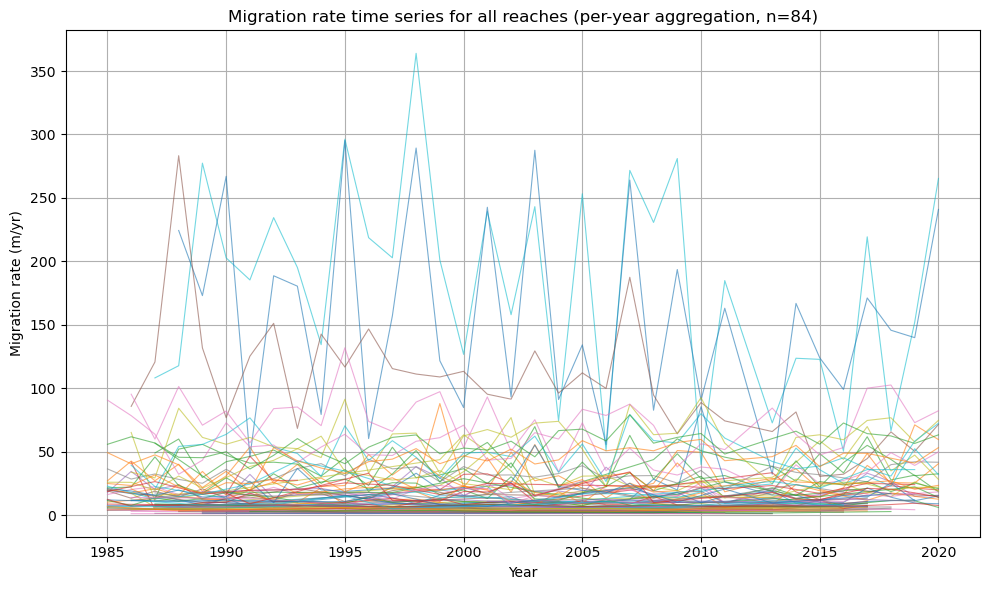

In [7]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

def unwrap(x):
    if isinstance(x, np.ndarray) and x.dtype == object:
        if x.size == 1:
            return unwrap(x.ravel()[0])
        parts = []
        for xi in x.ravel():
            arr = unwrap(xi)
            if arr is not None and arr.size > 0:
                parts.append(np.asarray(arr).ravel())
        return np.concatenate(parts) if parts else np.array([])
    return np.array(x).ravel()

def aggregate_by_year(t_raw, v_raw, agg='median'):
    t = unwrap(t_raw).astype(float)
    v = unwrap(v_raw).astype(float)
    if t.size == 0 or v.size == 0:
        return np.array([]), np.array([])

    years_seq = t.astype(int)
    uniq_years, counts = np.unique(years_seq, return_counts=True)

    # If v already has one value per unique year (common in your file)
    if v.size == uniq_years.size:
        return uniq_years, v

    # Otherwise, aggregate v over each year block by consuming sequentially
    vals = []
    idx = 0
    for c in counts:
        take = min(c, max(0, v.size - idx))
        if take <= 0:
            vals.append(np.nan)
        else:
            chunk = v[idx:idx+take]
            vals.append(np.nanmedian(chunk) if agg == 'median' else np.nanmean(chunk))
            idx += take
    return uniq_years, np.asarray(vals)

# Load your file
mat_data = sio.loadmat(r"C:\Users\Feifei\Box\BR_remote_sensing\PIV\Log.mat")
Log = mat_data["Log"][0,0]
t_all = Log["t"].squeeze()
v_all = Log["v"].squeeze()

plt.figure(figsize=(10,6))
n_plotted = 0
for i in range(len(t_all)):
    years, vals = aggregate_by_year(t_all[i], v_all[i], agg='median')
    if years.size == 0 or vals.size == 0:
        continue
    mask = ~np.isnan(vals)
    years, vals = years[mask], vals[mask]
    if years.size == 0:
        continue
    order = np.argsort(years)
    plt.plot(years[order], vals[order], '-', linewidth=0.8, alpha=0.6)
    n_plotted += 1

plt.xlabel("Year")
plt.ylabel("Migration rate (m/yr)")
plt.title(f"Migration rate time series for all reaches (per-year aggregation, n={n_plotted})")
plt.grid(True)
plt.tight_layout()
plt.show()




In [15]:
from pymannkendall import original_test

mig_results = []

for i in range(len(t_all)):
    years, vals = aggregate_by_year(t_all[i], v_all[i], agg='median')
    if years.size == 0 or vals.size == 0:
        continue

    mask = ~np.isnan(vals)
    years, vals = years[mask], vals[mask]
    if years.size < 3 or np.unique(vals).size < 2:
        trend, pval = "no trend", np.nan
    else:
        try:
            mk = original_test(vals)
            trend, pval = mk.trend, mk.p
        except ZeroDivisionError:
            trend, pval = "no trend", np.nan

    mig_results.append({
        "ReachIndex": i,
        "Migration_trend": trend,
        "Migration_p_value": pval
    })

mig_df = pd.DataFrame(mig_results)


C:\Users\Feifei\AppData\Local\Temp\ipykernel_34984\2651667542.py:39: RuntimeWarning: All-NaN slice encountered
  vals.append(np.nanmedian(chunk) if agg == 'median' else np.nanmean(chunk))


In [17]:
# unwrap helper (already defined earlier)
def unwrap(x):
    if isinstance(x, np.ndarray) and x.dtype == object:
        if x.size == 1:
            return unwrap(x.ravel()[0])
        parts = []
        for xi in x.ravel():
            arr = unwrap(xi)
            if arr is not None and arr.size > 0:
                parts.append(np.asarray(arr).ravel())
        return np.concatenate(parts) if parts else np.array([])
    return np.array(x).ravel()

# Extract reach names from Log.mat
reach_names = [str(unwrap(r)[0]) if unwrap(r).size > 0 else f"reach_{i}"
               for i, r in enumerate(Log["reach"].squeeze())]

# Add reach names to migration results
mig_df = pd.DataFrame(mig_results)
mig_df["River"] = [reach_names[i] for i in mig_df["ReachIndex"]]

# Now merge on 'River' (string-to-string)
combined = results_df.merge(mig_df, on="River", how="inner")


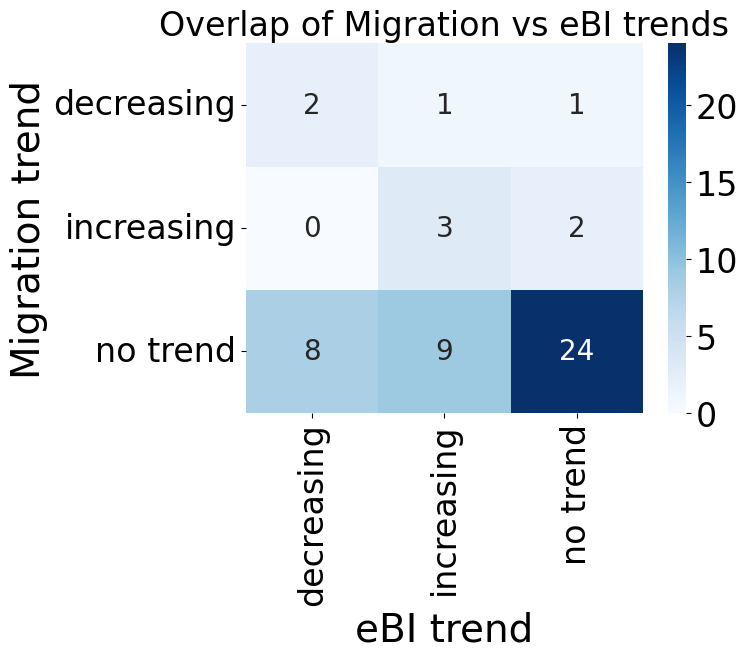

In [18]:
import seaborn as sns

contingency = pd.crosstab(combined["Migration_trend"], combined["eBI_trend"])
sns.heatmap(contingency, annot=True, fmt="d", cmap="Blues")
plt.title("Overlap of Migration vs eBI trends")
plt.xlabel("eBI trend")
plt.ylabel("Migration trend")
plt.show()
